### README
# Optimizing Engagement for Debt Recovery Emails

## Objective
The primary objective of this project is to determine the optimal date and time to send an email to a customer to maximize the likelihood of the customer clicking on the email. The methodology employed is tailored depending on whether the customer has previously received an email.    
- Notes: I partitioned the data into first time messages and repeat messages, revealing a notable difference in model performance between the two. This distinction significantly influenced the EDA and feature selections, prompting me to create separate versions for each. Given that all the customers in our dataset have received messages before, I used the non_first_time_msgs model for predictions.

## Key Insights from Exploratory Data Analysis (EDA)(can be found in 'repeat_msgs.ipynb')

- **Dataset Distribution**: The dataset is imbalanced with only 6.4% of the emails being clicked, and just 2.2% leading to a conversion.
- **Demographics**: A majority of customers are male, predominantly from the UK. The age distribution is broad, ranging from 18 to 96, with a mean of 43.
- **Email Timing**: Emails are chiefly sent during working hours, between 8 am to 7 pm, on weekdays.

## Data Preparation & Pipeline

- **Dataset Construction**: Merged all possible weekday and time combinations for each customer to provide a comprehensive foundation for prediction.
- **Encoding & Imputation**: Encoded categorical variables and filled missing data using a MICE model to ensure no data leakage and retention of the data's statistical properties.
- **Resampling**: Given the extremely imbalanced nature of the data, I used SMOTE to oversample the "clicked" group. Resampling should only be applied to the training data and not to new data to prevent information leakage. The pipeline can be found in 'repeat_msgs.ipynb'.

## Feature Engineering

- **Segmentation**: Features like client_country, age_group, hour, and weekday were introduced to capture demographic and timing effects.
- **Engagement Patterns**: Metrics like time_since_last_msg, past_click_rate, and past_convert_rate were incorporated to gauge historical responsiveness.
- **Time Series Analysis**: `date` was utilized to discern chronological engagement trends.

## Modeling Approach & Observations

### First-Time Messages:
- The Random Forest model achieved the best performance with an F1 score of 0.51, balancing precision and recall.
- Considering the smaller size of first time messages, more data may need for robustness and generallizability

### Repeat Messages:
- Noted a distinct correlation pattern between `time_since_last_msg` and weekday, implying that the elapsed time since the last email varies by the day of the week. It could be explained by the mails only sent in weekdays or current scheduled campaigns...
- The best model for this group, Logistic Regression, achieved an F1 score of 0.26, indicating potential areas for improvement.

## Predicting Optimal Email Timing

- Generated a comprehensive dataset with all customer-weekday-hour combinations.
- Applied the model tailored for repeat recipients, given the historical data.
- Post feature engineering, imputation, and standardization, derived model predictions.
- Identified the time slot with the maximum click probability for each customer and formatted the results in ISO format.

## Recommendations & Further Steps

- **Business Context**: For sensitive debt recovery emails, closely aligning the modeling process with business goals is crucial.
- **Model Enhancement**: Delve deeper into feature engineering and consider model fine-tuning. XGBoost, given its proven track record in similar problems, could be explored further.
- **Analyze Outliers**: Investigate anomalies to understand patterns leading to higher engagement.
- **Correlation Analysis**: Probe deeper into relationships, such as the observed correlation between weekday and `time_since_last_msg`.
- **Expand Algorithmic Scope**: Consider other algorithms like SVM and deep learning for potential insights and performance enhancement.

- **The other points for further investigation:
  1.there is an accumlation trend of month for clicked and converted till October. Is that caused by stratigic or techincal issues?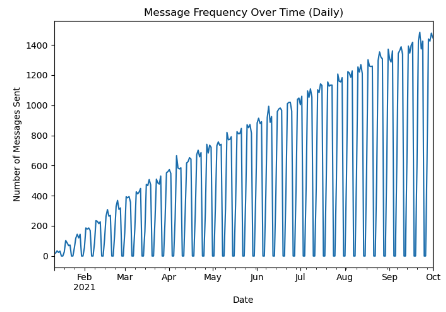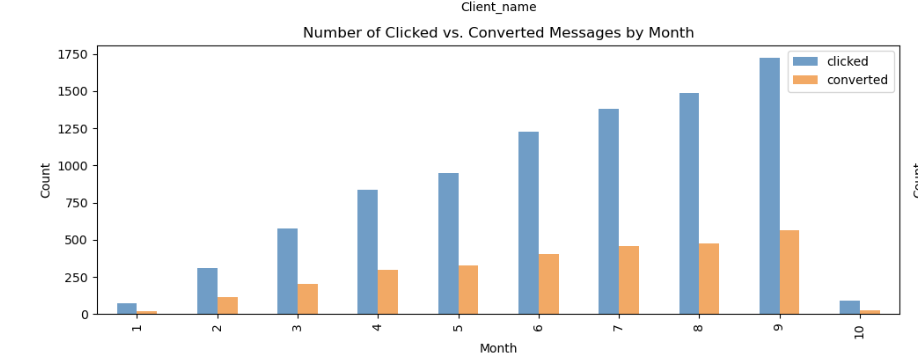
  2.Most people have a past click rate around 0.1 to 0.2, but there are several outliers with higher click rates. This indicates that while a majority might not frequently click on such emails, there's a subset engage more with these emails.Figure it out why.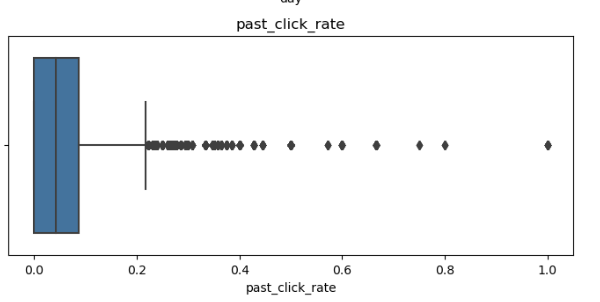
  3.The time_since_last_msg is highly correlated with the weekday.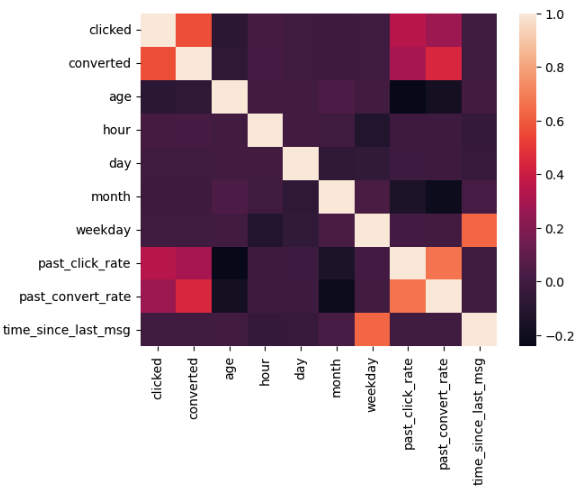

## Materials and References(can be found in the folder):

- **Datasets**:
    - Merged Data: `merged_data.csv`
    - Processed Data: `past_click_rate.csv`
    - Prediction Data: `predictions_data.csv`

- **Models**:
    - MICE Imputer Model: `mice_imputer.pkl`
    - Logistic Regression Model: `pipeline.pkl`
    
- **Notebooks**:
    - First time messages: `2_new_msgs.ipynb`
    - Repeat messages: `1_repeat_msgs.ipynb`

- **References**:
    1. [Predicting the Optimal Date and Time to Send Personalized Marketing Messages to Repeat Buyers](https://www.researchgate.net/publication/341078210_Predicting_the_Optimal_Date_and_Time_to_Send_Personalized_Marketing_Messages_to_Repeat_Buyers)
    2. [Optimize Email Marketing with Machine Learning](https://www.width.ai/post/optimize-email-marketing-with-machine-learning#:~:text=Optimal%20Date%20%26%20Time%20Prediction,through%20rates)
    


In [23]:
#library imports
import pandas as pd
import pickle
import joblib

In [24]:
#data loading
#data is from merge the clients, customers and messages tables 
data = pd.read_csv("merged_data.csv",index_col=0)
past_click_rate = pd.read_csv("past_click_rate.csv",index_col=0)

In [25]:
#model loading
# Load the saved MICE imputer
with open('mice_imputer.pkl', 'rb') as file:
    loaded_imputer = pickle.load(file)

1. **Data Construction**:
   - Construct new datasets incorporating all customers to be predicted.
   - Include all combinations of weekdays and hours.

In [26]:
# List of unique customers
unique_customers = data['customer_id'].unique()

# Given constraints
allowed_hours = {
    'UK': list(range(8, 21)),  # 8am to 8pm
    'CA': list(range(9, 18)),  # 9am to 5pm
    'NZ': list(range(9, 19))   # 9am to 6pm
}

# Days in October from 4th to 10th
days_of_week = [0, 1, 2, 3, 4]  # Assuming 0=Monday..,no weekends

# Create combinations
combinations = []

for customer in unique_customers:
    country = data[data['customer_id'] == customer]['country'].iloc[0]
    for day in days_of_week:
        for hour in allowed_hours[country]:
            combinations.append([customer, day, hour])

# Convert to DataFrame
combinations_df = pd.DataFrame(combinations, columns=['customer_id', 'weekday', 'hour'])

print(combinations_df.head())


                        customer_id  weekday  hour
0  f13e966f9dc1e2aa7bffec6c9efa8e11        0     8
1  f13e966f9dc1e2aa7bffec6c9efa8e11        0     9
2  f13e966f9dc1e2aa7bffec6c9efa8e11        0    10
3  f13e966f9dc1e2aa7bffec6c9efa8e11        0    11
4  f13e966f9dc1e2aa7bffec6c9efa8e11        0    12


In [27]:
#merge the existing features to the new dataset 
columns_to_merge = ['customer_id', 'gender', 'age', 'country', 'client_name', 'product_type']
merged_combinations = pd.merge(combinations_df, data[columns_to_merge], on='customer_id', how='left')
# Remove duplicates
merged_combinations = merged_combinations.drop_duplicates().reset_index(drop=True)
print(merged_combinations.shape)
print(merged_combinations.head())

(553690, 8)
                        customer_id  weekday  hour gender   age country  \
0  f13e966f9dc1e2aa7bffec6c9efa8e11        0     8      F  51.0      UK   
1  f13e966f9dc1e2aa7bffec6c9efa8e11        0     9      F  51.0      UK   
2  f13e966f9dc1e2aa7bffec6c9efa8e11        0    10      F  51.0      UK   
3  f13e966f9dc1e2aa7bffec6c9efa8e11        0    11      F  51.0      UK   
4  f13e966f9dc1e2aa7bffec6c9efa8e11        0    12      F  51.0      UK   

  client_name product_type  
0     SwanPay         BNPL  
1     SwanPay         BNPL  
2     SwanPay         BNPL  
3     SwanPay         BNPL  
4     SwanPay         BNPL  


2. **Data Preparation**:
   - Encode the categorical features.
   - Conduct imputation for missing values. It's crucial to only train the MICE model on the training data and then apply the transformation to the test data. Training on the entire dataset could lead to information leakage.
   - **Resampling**: Due to the dataset being highly imbalanced, I employed SMOTE to oversample the minority data (clicked instances) to enhance model performance. Note: Resampling was only applied to the training data and not to the new data.
   - Standardize the data, making it suitable for modeling.


In [28]:
#encoding
def encode_features(data):
    # Encoding gender
    data['gender_encoded'] = data['gender'].map({'F':0, 'M':1})

    # Encoding country
    data['country_encoded'] = data['country'].map({'UK':0,'CA':1,'NZ':2})

    # Encoding client_name
    client_name_mapping = {
        'SwanPay':0,'Fox Energy':1,'Badgerbank':2,'KiwiPay':3,
        'Skink Solar':4,'Beaver Bank':5,'Moose Money':6,
        'Eagle Energy':7
    }
    data['client_name_encoded'] = data['client_name'].map(client_name_mapping)

    # Encoding product_type
    data['product_type_encoded'] = data['product_type'].map({'BNPL':0,'CreditCard':1,'Energy':2})
    
    return data

# Using the function:
merged_combinations_encoded = encode_features(merged_combinations)



In [29]:
#missing value imputation
#Use the loaded imputer to transform new data
merged_combinations[['gender_encoded', 'age']] = loaded_imputer.transform(merged_combinations[['gender_encoded', 'age']])
merged_combinations['gender_encoded'] = merged_combinations['gender_encoded'].round().astype(int)

3. **Feature Engineering**:
   - Apply the established feature engineering pipeline to the newly constructed data.

In [30]:
#add the past_click_rate
merged_combinations = pd.merge(merged_combinations, past_click_rate,how="left", on="customer_id")

#add the age_group
def get_age_group(age):
    if age < 30:
        return 0#young
    elif 30 <= age < 50:
        return 1#middle_age
    else:
        return 2#senior
    
merged_combinations['age_group'] = merged_combinations['age'].apply(get_age_group)

#add month column
merged_combinations["month"] = 10
#add year column
merged_combinations["year"] = 2021

#add day to the data,no weekend 
weekday_to_day_map = {
    0:4,
    1:5,
    2:6,
    3:7,
    4:8
}
merged_combinations["day"] = merged_combinations["weekday"].map(weekday_to_day_map)

In [31]:
#The final dataset formated as the traing data
features = ['age', 'hour', 'day', 'month', 'weekday', 'past_click_rate',
       'gender_encoded', 'country_encoded', 'client_name_encoded',
       'product_type_encoded', 'age_group']
final_data = merged_combinations[features]

4. **Model Selection**:
   - Opt for the repeat recipients model in 'non_first_time_msgs.ipynb' since all customers have received at least one message previously.

In [33]:
# Load the saved pipeline
loaded_pipeline = joblib.load('pipeline.pkl')

# Use the pipeline to predict on new data
predictions = loaded_pipeline.predict(final_data)

5. **Probability Estimation**:
   - Predict the probability that a message will be clicked by the recipient.

6. **Optimal Time Slot Identification**:
   - Identify the time slot with the maximum click probability for each customer.

7. **Conversion**:
   - Convert the identified best weekday and time to the ISO format.

In [42]:
#get the clicked probability
merged_combinations["prob"] = loaded_pipeline.predict_proba(final_data)[:,1]
results  = merged_combinations[["customer_id","year","month","day","hour","prob"]]
#get the optimal probability for individual customers
idx = results.groupby("customer_id")["prob"].idxmax()
max_prob_records = results.loc[idx]
#convert to ISO format
max_prob_records['datetime'] = pd.to_datetime(max_prob_records[['year', 'month', 'day', 'hour']]).dt.strftime('%Y-%m-%dT%H:%M:%S')
recommendation = max_prob_records[["customer_id","datetime"]].reset_index(drop=True)
recommendation

,customer_id,datetime
0,00043de85b74cba03f23dfe600b781bb,2021-10-04T08:00:00
1,0004a5f5de52a32daabb66e9c69ca05a,2021-10-04T09:00:00
2,0021b8a5c5747c1b2cdca92c54d68d2b,2021-10-04T09:00:00
3,002cb5e3ce196755e4705e3ce2253077,2021-10-04T09:00:00
4,0033da85f997a74fdffc322dc6f6d217,2021-10-04T08:00:00
...,...,...
9746,ffe024dcd6ec4d3798127503d4dbb8ed,2021-10-04T09:00:00
9747,ffed8cc72339800f9312982f67fdb403,2021-10-04T08:00:00
9748,ffeed42a799e49253f4d048ff3f84383,2021-10-04T08:00:00
9749,fff1f1798eb141b66a110fb7e1fc56d9,2021-10-04T08:00:00


In [43]:
recommendation.to_csv("predictions_data.csv",index=False)

It's unexpected to observe that all the recommended datetimes fall on 2021-10-04 between 8 am and 9 am. This result warrants further investigation to ascertain if these truly represent the optimal times to maximize click rates. Given the time limit, the recommend future improvement includes:

- Reassess the distribution of the training data, especially around the target variable.
- Examine the coefficients of the logistic regression model to understand feature importance and influence.
- Experiment with different resampling techniques or adjust the strategy.
- Incorporate more data or additional features to provide the model with a richer context.e.g., industry
- Focus on fine tuning of the models
- Use cross validation to ensure the encoding and models work well